# NMA Robolympics: Controlling robots using reinforcement learning

**By Neuromatch Academy**

__Content creators:__ Roman Vaxenburg, Diptodip Deb, Srinivas Turaga

__Production editors:__ Spiros Chavlis

**Our 2021 Sponsors, including Presenting Sponsor Facebook Reality Labs**

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

---
# Objective

This notebook provides a minimal but complete example of the reinforcement learning infrastructure, training sequence, and result visualization. We will use a [pybullet](https://github.com/bulletphysics/bullet3) locomotion environment and [dm-acme](https://github.com/deepmind/acme) reinforcement learning agents to learn a policy to perform a simple task with the 2D `Hopper` robot. 

We will show how to create and inspect the environment and how to start modifying it to have robots perform various tasks. This example should provide a good starting point for your own exploration!

Even though this example uses a very simple robot, you can start experimenting with more complicated ones, such as `Ant` and `Humanoid` by just importing and modifying them as shown in this example. Also, start exploring the source code of the environments so you can modify them more easily later.

We would also suggest going over the `dm-acme` tutorial notebook:

https://github.com/deepmind/acme/blob/master/examples/tutorial.ipynb

For a general introduction to Reinforcement Learning, it's worth checking out this course:

https://deepmind.com/learning-resources/-introduction-reinforcement-learning-david-silver


# Colab limits

Please note that due to the Colab usage limits on the one hand, and the compute requirements of the project on the other hand, most likely you won't be able to leverage Colab's GPU for a sufficient amount of time. Instead, we suggest working in CPU-only mode (it shouldn't slow you down very much, typical RL workloads are CPU-bound anyway). Make sure you're not using GPU by doing Runtime -> Change runtime type -> Hardware accelerator -> None.

Also, when instantiating the environments, make sure to keep the default setting `render=False`.

---
# Setup

In [ ]:
# @title Install dependencies
# @markdown In the first cell we'll install all of the necessary dependencies.
from IPython.display import clear_output
!sudo apt-get -q install ffmpeg freeglut3-dev xvfb  # For visualization.

!pip install tensorflow --quiet
!pip install dm-sonnet --quiet
!pip install imageio-ffmpeg --quiet
!pip install pybullet --quiet
!pip install dm-acme[tf]==0.2.0 dm-acme[reverb]==0.2.0 --quiet

clear_output()

In [ ]:
# Imports
import os
import shutil
import matplotlib
import pybullet_envs

from acme.utils import loggers
from acme.tf import networks
from acme.tf import utils as tf2_utils
from acme.agents.tf.d4pg import D4PG
from acme.agents.tf.ddpg import DDPG
from acme.agents.tf.dmpo import DistributionalMPO
from acme import wrappers, specs, environment_loop

import numpy as np
import sonnet as snt
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from google.colab import drive
from IPython.display import HTML

In [ ]:
# @title Import `pybullet` locomotion environments

from pybullet_envs.gym_locomotion_envs import HopperBulletEnv
from pybullet_envs.gym_locomotion_envs import Walker2DBulletEnv
from pybullet_envs.gym_locomotion_envs import HalfCheetahBulletEnv
from pybullet_envs.gym_locomotion_envs import AntBulletEnv
from pybullet_envs.gym_locomotion_envs import HumanoidBulletEnv

In [ ]:
# @title Figure settings
import ipywidgets as widgets       # interactive display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

---
# Functions for saving and restoring checkpoints
Due to Colab usage limits, the Colab runtime will be restarting periodically. In order to preserve the most recent training checkpoint during a restart, please use the functions below.

To do so, you'll have to first mount Google Drive (will be shown below).

### Before runtime restart:
Use `save_ckpt_to_drive` to locate the checkpoint and save it to your Google Drive in a directory `/acme_ckpt`

### After runtime restart:
Use `restore_ckpt_from_drive` to recover the checkpoint from Google Drive and copy it back to the restarted Colab virtual machine.

In [ ]:
def save_ckpt_to_drive(agent):
  """Saves agent checkpoint directory to Google Drive.

  WARNING: Will replace the entire content of the
  drive directory `/root/drive/MyDrive/acme_ckpt`.

  Args:
    agent: core.Actor
  """
  src = agent._learner._checkpointer._checkpoint_manager.directory
  dst = '/content/drive/MyDrive/nma_rl/acme_ckpt'
  if os.path.exists(dst):
    shutil.rmtree(dst)
  shutil.copytree(src, dst)
  print(f'Saved {src} to {dst}')


def restore_ckpt_from_drive(agent):
  """Restores agent checkpoint directory from Google Drive.

  The name of the local checkpoint directory will be different
  than it was when the checkpoint was originally saved.
  This is because `acme` checkpoiner creates a new directory
  upon restart.

  WARNING: Will replace the entire content of the local
  checkpoint directory (if it exists already).

  Args:
    agent: core.Actor
  """
  src = '/content/drive/MyDrive/nma_rl/acme_ckpt'
  dst = agent._learner._checkpointer._checkpoint_manager.directory
  if os.path.exists(dst):
        shutil.rmtree(dst)
  shutil.copytree(src, dst)
  print(f'Restored {dst} from {src}')

---
# Convenience function for creating videos

Use this function to generate videos of your experiments.

In [ ]:
def display_video(frames, framerate=30):
  """Generates video from `frames`.

  Args:
    frames (ndarray): Array of shape (n_frames, height, width, 3).
    framerate (int): Frame rate in units of Hz.

  Returns:
    Display object.
  """
  height, width, _ = frames[0].shape
  dpi = 70
  orig_backend = matplotlib.get_backend()
  matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
  fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
  matplotlib.use(orig_backend)  # Switch back to the original backend.
  ax.set_axis_off()
  ax.set_aspect('equal')
  ax.set_position([0, 0, 1, 1])
  im = ax.imshow(frames[0])
  def update(frame):
    im.set_data(frame)
    return [im]
  interval = 1000/framerate
  anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                  interval=interval, blit=True, repeat=False)
  return HTML(anim.to_html5_video())

---
# Network factory methods for select continuous control agents
The functions below initialize and return the policy and critic networks for several continuous control agents (DDPG, D4PG, DMPO) used later in this notebook. Feel free to explore other agents as well. For more information on these and other agents, their implementations, and links to their corresponding papers see
https://github.com/deepmind/acme/tree/master/acme/agents

Please note that the hyperparameters `layer_sizes`, `vmin`, `vmax`, `num_atoms` are set to reasonable default values, but may reqiure adjustment. Especially, `vmin` and `vmax` should be used with care. Please see, e.g., https://github.com/deepmind/acme/blob/master/acme/agents/tf/d4pg/README.md for more information.

In [ ]:
def make_networks_d4pg(action_spec,
                       policy_layer_sizes=(256, 256, 256),
                       critic_layer_sizes=(512, 512, 256),
                       vmin=-150.,
                       vmax=150.,
                       num_atoms=51,
                      ):
  """Networks for D4PG agent."""
  action_size = np.prod(action_spec.shape, dtype=int)

  policy_network = snt.Sequential([
      tf2_utils.batch_concat,
      networks.LayerNormMLP(layer_sizes=policy_layer_sizes + (action_size,)),
      networks.TanhToSpec(spec=action_spec)
      ])
  critic_network = snt.Sequential([
      networks.CriticMultiplexer(
          action_network=networks.ClipToSpec(action_spec),
          critic_network=networks.LayerNormMLP(
              layer_sizes=critic_layer_sizes,
              activate_final=True),
      ),
      networks.DiscreteValuedHead(vmin=vmin,
                                  vmax=vmax,
                                  num_atoms=num_atoms)
      ])

  return policy_network, critic_network


def make_networks_ddpg(action_spec,
                       policy_layer_sizes=(256, 256, 256),
                       critic_layer_sizes=(512, 512, 256),
                      ):
  """Networks for DDPG agent."""
  action_size = np.prod(action_spec.shape, dtype=int)

  policy_network = snt.Sequential([
      tf2_utils.batch_concat,
      networks.LayerNormMLP(layer_sizes=policy_layer_sizes + (action_size,)),
      networks.TanhToSpec(spec=action_spec)
      ])
  critic_network = networks.CriticMultiplexer(
          action_network=networks.ClipToSpec(action_spec),
          critic_network=networks.LayerNormMLP(
              layer_sizes=critic_layer_sizes + (1,),
              activate_final=False),
              )

  return policy_network, critic_network


def make_networks_dmpo(action_spec,
                       policy_layer_sizes=(256, 256, 256),
                       critic_layer_sizes=(512, 512, 256),
                       vmin=-150.,
                       vmax=150.,
                       num_atoms=51,
                      ):
  """Networks for DMPO agent."""
  action_size = np.prod(action_spec.shape, dtype=int)

  policy_network = snt.Sequential([
      tf2_utils.batch_concat,
      networks.LayerNormMLP(layer_sizes=policy_layer_sizes,
                            activate_final=True),
      networks.MultivariateNormalDiagHead(
          action_size,
          min_scale=1e-6,
          tanh_mean=False,
          init_scale=0.7,
          fixed_scale=False,
          use_tfd_independent=True)
  ])

  # The multiplexer concatenates the (maybe transformed) observations/actions.
  critic_network = networks.CriticMultiplexer(
      action_network=networks.ClipToSpec(action_spec),
      critic_network=networks.LayerNormMLP(layer_sizes=critic_layer_sizes,
                                           activate_final=True),
                                           )
  critic_network = snt.Sequential([
                                   critic_network,
                                   networks.DiscreteValuedHead(vmin=vmin,
                                                               vmax=vmax,
                                                               num_atoms=num_atoms)
                                   ])

  return policy_network, critic_network

---
# List of all `pybullet` environments

You can print the full list of environments by running the cell below. Only a subset of them are locomotion environments but feel free to explore the other ones if you're interested.

In [ ]:
pybullet_envs.getList()

['- HumanoidDeepMimicBackflipBulletEnv-v1',
 '- HumanoidDeepMimicWalkBulletEnv-v1',
 '- CartPoleBulletEnv-v1',
 '- CartPoleContinuousBulletEnv-v0',
 '- MinitaurBulletEnv-v0',
 '- MinitaurBulletDuckEnv-v0',
 '- RacecarBulletEnv-v0',
 '- RacecarZedBulletEnv-v0',
 '- KukaBulletEnv-v0',
 '- KukaCamBulletEnv-v0',
 '- InvertedPendulumBulletEnv-v0',
 '- InvertedDoublePendulumBulletEnv-v0',
 '- InvertedPendulumSwingupBulletEnv-v0',
 '- ReacherBulletEnv-v0',
 '- PusherBulletEnv-v0',
 '- ThrowerBulletEnv-v0',
 '- Walker2DBulletEnv-v0',
 '- HalfCheetahBulletEnv-v0',
 '- AntBulletEnv-v0',
 '- HopperBulletEnv-v0',
 '- HumanoidBulletEnv-v0',
 '- HumanoidFlagrunBulletEnv-v0',
 '- HumanoidFlagrunHarderBulletEnv-v0',
 '- MinitaurExtendedEnv-v0',
 '- MinitaurReactiveEnv-v0',
 '- MinitaurBallGymEnv-v0',
 '- MinitaurTrottingEnv-v0',
 '- MinitaurStandGymEnv-v0',
 '- MinitaurAlternatingLegsEnv-v0',
 '- MinitaurFourLegStandEnv-v0',
 '- KukaDiverseObjectGrasping-v0']

---
# Modifying the environment base class

You may start your exploration of the `pybullet` locomotion environment code from this entry point, going up and down the hierarchy of classes:

https://github.com/bulletphysics/bullet3/blob/master/examples/pybullet/gym/pybullet_envs/gym_locomotion_envs.py

For our experiments, we will be using the `pybullet` locomotion environments with several different robots (`Hopper`, `Ant`, `Humanoid`, etc.). In order to have the robots perform different tasks, we'll need to modify some parts of the environments' code. This will (mainly) amount to modifying the environments' reward calculation in the `step` method.

In the cell below we provide a minimal example modifying the `HopperBulletEnv` environment class. Normally, to create a Hopper environment you would just create an instance of the HopperBulletEnv class:

```
env = HopperBulletEnv()
```
However, if you analyze the environment's code, you'll realize that making changes (such as modifying the reward calculation) is difficult in this way. Instead, it's useful to create a custom child class inheriting from the original `HopperBulletEnv` class and override some of its methods. This subclassing will allow you to easily access the interesting pieces of the environment class to modify.

In the example of a custom `Hopper` class below, we override several methods of its parent class to (i) make the reward calculation modifiable, (ii) add `step_counter` to enforce fixed episode duration, and (iii) make the episode termination conditions modifiable. Please note that in some cases the overriding methods still call their parent methods after executing the required modifications (such as the `__init__`, `reset`, `_isDone` methods do.). In contrast, the `step` method is overriden in its entirety and doesn't reference its parent method. So instead of the code line above, the environment would be created as:
```python
env = Hopper()
```
You can use this approach and this example as the starting point of your project. In many cases, this custom class can be used as is (with only a name change) with other robots in the `pybullet` locomotion environments by inheriting from their respective original environment classes instead of from `HopperBulletEnv`.

In [ ]:
# class Hopper(HopperBulletEnv):

#   def __init__(self, render=False, episode_steps=1000):
#     """Modifies `__init__` in `HopperBulletEnv` parent class."""
#     self.episode_steps = episode_steps
#     super().__init__(render=render)

#   def reset(self):
#     """Modifies `reset` in `WalkerBaseBulletEnv` base class."""
#     self.step_counter = 0
#     return super().reset()

#   def _isDone(self):
#     """Modifies `_isDone` in `WalkerBaseBulletEnv` base class."""
#     return (self.step_counter == self.episode_steps
#             or super()._isDone())

#   def step(self, a):
#     """Fully overrides `step` in `WalkerBaseBulletEnv` base class."""

#     self.step_counter += 1

#     # if multiplayer, action first applied to all robots,
#     # then global step() called, then _step() for all robots
#     # with the same actions
#     if not self.scene.multiplayer:
#       self.robot.apply_action(a)
#       self.scene.global_step()

#     state = self.robot.calc_state()  # also calculates self.joints_at_limit

#     # state[0] is body height above ground, body_rpy[1] is pitch
#     self._alive = float(self.robot.alive_bonus(state[0] + self.robot.initial_z,
#                                                self.robot.body_rpy[1]))
#     done = self._isDone()
#     if not np.isfinite(state).all():
#       print("~INF~", state)
#       done = True

#     potential_old = self.potential
#     self.potential = self.robot.calc_potential()
#     progress = float(self.potential - potential_old)

#     feet_collision_cost = 0.0
#     for i, f in enumerate(self.robot.feet):
#       contact_ids = set((x[2], x[4]) for x in f.contact_list())
#       if (self.ground_ids & contact_ids):
#         self.robot.feet_contact[i] = 1.0
#       else:
#         self.robot.feet_contact[i] = 0.0

#     # let's assume we have DC motor with controller, and reverse current braking
#     electricity_cost = self.electricity_cost * float(
#         np.abs(a * self.robot.joint_speeds).mean())
#     electricity_cost += self.stall_torque_cost * float(np.square(a).mean())

#     joints_at_limit_cost = float(self.joints_at_limit_cost * self.robot.joints_at_limit)

#     self.rewards = [
#                     self._alive, progress, electricity_cost,
#                     joints_at_limit_cost, feet_collision_cost
#                     ]
#     self.HUD(state, a, done)
#     self.reward += sum(self.rewards)

#     return state, sum(self.rewards), bool(done), {}

---
# Instantiate the environment

Here, we are creating an example `Hopper` environment. Once created, we are wrapping it with `GymWrapper` to make the native `Gym` environment interface compatible with the one used in the `dm-acme` library, which is the reinforcement learning package that we will be using. `dm-acme` adheres to the interface defined here: https://github.com/deepmind/dm_env. Finally, we also use `SinglePrecisionWrapper` to enforce single-precision on a potentially double-precision environment.


In [ ]:
env = HopperBulletEnv(render=False)
# env = Hopper(render=False)
env.seed(101)
env.action_space.seed(101)
env.observation_space.seed(101)
env = wrappers.GymWrapper(env)
env = wrappers.SinglePrecisionWrapper(env)

action_spec = env.action_spec()  # Specifies action shape and dimensions.
env_spec = specs.make_environment_spec(env)  # Environment specifications.

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---
# The default task

If not modified, the default task of the `HopperBulletEnv` environment is to have the robot hop to the target location located 1 km away. The target location is stored as an attribute of the `robot` object and can be accessed as in the cell below.

The task also contains other constraints, such as `electricity_cost`, and certain episode termination conditions. Please start from our custom `Hopper` class in the above cell and work your way backwards to the the environment code for more details!

In [ ]:
# x and y coordinates of the target location.
env.robot.walk_target_x, env.robot.walk_target_y

(1000.0, 0)

---
# Let's inspect the environment a bit

#### Plot one frame of the environment

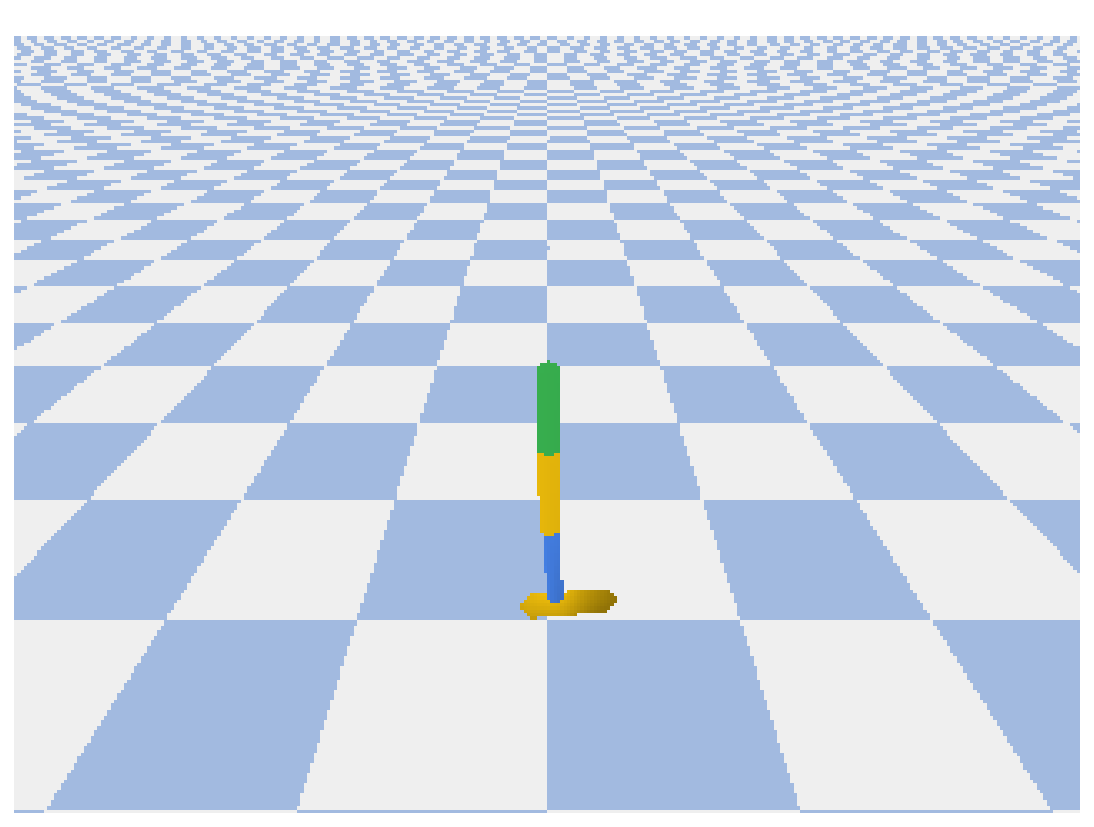

In [ ]:
_ = env.reset()

frame = env.environment.render(mode='rgb_array')
plt.imshow(frame)
plt.axis('off')
plt.show()

## Run the environment with random actions

We haven't trained the policy yet, but we can still see the environment in action by passing a random control sequence to it.

In [ ]:
# Run env for n_steps, apply random actions, and show video.
n_steps = 200

frames = []
timestep = env.reset()
# for _ in range(n_steps):
#   # Random control of actuators.
#   action = np.random.uniform(action_spec.minimum,
#                              action_spec.maximum,
#                              size=action_spec.shape)
#   timestep = env.step(action)
#   frames.append(env.environment.render(mode='rgb_array'))

# display_video(frames, framerate=20)

## Lets take a look at some other environment properties

Notice the shapes and min/max limits

In [ ]:
print('Actions:\n', env_spec.actions)
print('Observations:\n', env_spec.observations)
print('Rewards:\n', env_spec.rewards)

Actions:
 BoundedArray(shape=(3,), dtype=dtype('float32'), name='action', minimum=[-1. -1. -1.], maximum=[1. 1. 1.])
Observations:
 BoundedArray(shape=(15,), dtype=dtype('float32'), name='observation', minimum=[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf], maximum=[inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf])
Rewards:
 Array(shape=(), dtype=dtype('float32'), name='reward')


## Inspect some of the robot properties

Let's examine the (Cartesian) coordinates of different body parts of the robot and its speed. Notice that `robot` is an attribute of the `env` class. Also, note how the body parts are accessed as you may need it for adjusting the reward calculation in your project. 

Feel free to explore other properties (attributes) of the `env.robot` object, such as velocities, joint angles, etc.

In [ ]:
# Cartesian coordinates of body parts.
for body_part in env.robot.parts.keys():
  print(f"{body_part:10} {env.robot.parts[body_part].pose().xyz()}")

link0_2    [0. 0. 0.]
torso      [0.   0.   1.25]
link0_3    [0. 0. 0.]
link0_4    [0. 0. 0.]
link0_6    [8.67361738e-19 0.00000000e+00 1.04999995e+00]
thigh      [-0.01683335  0.          0.82563056]
link0_8    [-0.03366669  0.          0.60126118]
leg        [-0.06659153  0.          0.35343874]
link0_10   [-0.09951637  0.          0.1056163 ]
foot       [-0.03479607  0.          0.0995928 ]
floor      [0. 0. 0.]


In [ ]:
# Cartesian components of robot speed.
env.robot_body.speed()

array([0., 0., 0.])

---
# Create the `dm-acme` agent

Now we are ready to create the agent. Below we provide examples of creating instances of three select agents (DDPG, D4PG, DMPO) that we implemented above. Please feel free to explore other agents as well. For more information on these and other agents, their implementations, and links to their corresponding papers see
https://github.com/deepmind/acme/tree/master/acme/agents

The direct links to the implementation of these three agents for you to start exploring are:

https://github.com/deepmind/acme/blob/master/acme/agents/tf/ddpg/agent.py

https://github.com/deepmind/acme/blob/master/acme/agents/tf/d4pg/agent.py

https://github.com/deepmind/acme/blob/master/acme/agents/tf/dmpo/agent.py


First, lets configure loggers and optimizers:

In [ ]:
env

In [ ]:
learner_log_every = 60.  # Learner logging frequency, seconds.
loop_log_every = 60.  # Environment loop logging frequency, seconds.
checkpoint = True  # Checkpoint saved every 10 minutes.

# learner_logger = loggers.TerminalLogger(label='Learner',
#                                         time_delta=learner_log_every,
#                                         print_fn=print)
# loop_logger = loggers.TerminalLogger(label='Environment Loop',
#                                      time_delta=loop_log_every,
#                                      print_fn=print)

learner_logger = loggers.CSVLogger(label='Hopper_Learner',
                                        time_delta=learner_log_every)
loop_logger = loggers.CSVLogger(label='Hopper_Environment_Loop',
                                     time_delta=loop_log_every)

# Note: optimizers can be passed only to the D4PG and DMPO agents.
# The optimizer for DDPG is hard-coded in the agent class.
policy_optimizer = snt.optimizers.Adam(5e-5)
critic_optimizer = snt.optimizers.Adam(5e-5)

---
# D4PG agent

As an example, in the next cell we instantiate the D4PG agent. Examples of other agents (DDPG, DMPO) are provided at the end of the notebook.

In [ ]:
# Create networks.
policy_network, critic_network = make_networks_d4pg(action_spec)

# Create agent.
agent = D4PG(environment_spec=env_spec,
             policy_network=policy_network,
             critic_network=critic_network,
             observation_network=tf2_utils.batch_concat, # Identity Op.
             policy_optimizer=policy_optimizer,
             critic_optimizer=critic_optimizer,
             logger=learner_logger,
             checkpoint=checkpoint)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function make_reverb_dataset.<locals>._make_dataset at 0x7ff610fc8680>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function make_reverb_dataset.<locals>._make_dataset at 0x7ff610fc8680>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function make_reverb_dataset.<locals>._make_dataset at 0x7ff610fc8680>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <bound method Snapshot.__call__ of <tensorflow.python.eager.function.TfMethodTarget object at 0x7

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <bound method Snapshot.__call__ of <tensorflow.python.eager.function.TfMethodTarget object at 0x7ff625bb1290>>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <bound method Snapshot.__call__ of <tensorflow.python.eager.function.TfMethodTarget object at 0x7ff625bb1290>>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function make_snapshot.<locals>.wrapped_module at 0x7ff60

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function make_snapshot.<locals>.wrapped_module at 0x7ff608b3c9e0>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function make_snapshot.<locals>.wrapped_module at 0x7ff608b3c9e0>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function make_snapshot.<locals>.wrapped_module at 0x7ff6002c70e0>. Note that functions defined in cer

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function make_snapshot.<locals>.wrapped_module at 0x7ff6002c70e0>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function make_snapshot.<locals>.wrapped_module at 0x7ff6002c70e0>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


---
# Training

Finally, we are ready to start training!

Please refer to the source code to see how to use the environment loop:

https://github.com/deepmind/acme/blob/master/acme/environment_loop.py

The training checkpoint (containing the network weights, optimizer parameters, etc.) will be saved every 10 minutes. Please remember to save and then restore the checkpoint from Google Drive if you are restarting the Colab runtime. See example below.

*Note:* `num_steps = 100_000` but we reduce it to 1000 to reduce computational time. Please change it back if you want to see the original output of the model.

In [ ]:
num_steps = 1_000_000 # 100_000  # Number of environment loop steps. Adjust as needed!

loop = environment_loop.EnvironmentLoop(env, agent, logger=loop_logger)

# Start training!
loop.run(num_episodes=None,
         num_steps=num_steps)

In [ ]:
loop._logger._file.close()

In [ ]:
learner_logger._file.close()

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('/root/acme/985f4298-f9b4-11eb-a762-0242ac1c0002/logs/Hopper_Environment_Loop/logs.csv')

In [ ]:
df['returns_p_eps'] = df.episode_return/df.episodes

In [ ]:
df

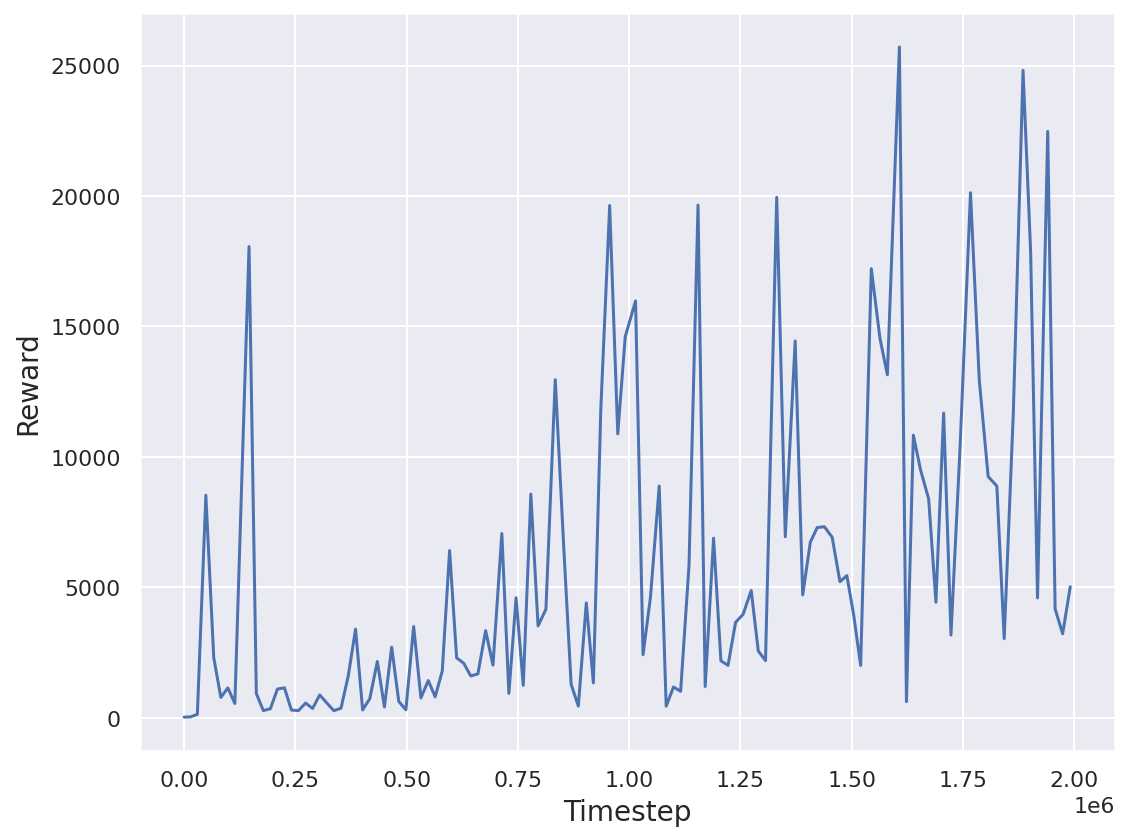

In [ ]:
plt.style.use('seaborn-bright')
import seaborn as sns
sns.set_theme()
plt.plot(df.steps, df.episode_return)
plt.xlabel('Timestep', fontsize=14)
plt.ylabel('Reward', fontsize=14)
# plt.grid()
plt.show()

## Examine trained policy

As the policy has (hopefully) been trained by now, let's test it in the environment and examine the result.

Note that we will also collect the reward at each timestep and plot it later.

In [ ]:
# Run the environment with the learned policy and display video.
n_steps = 1000

frames = []  # Frames for video.
reward = [[]]  # Reward at every timestep.
timestep = env.reset()
for _ in range(n_steps):
  frames.append(env.environment.render(mode='rgb_array').copy())
  action = agent.select_action(timestep.observation)
  timestep = env.step(action)

  # `timestep.reward` is None when episode terminates.
  if timestep.reward:
    # Old episode continues.
    reward[-1].append(timestep.reward.item())
  else:
    # New episode begins.
    reward.append([])

display_video(frames)

## Plot the reward

Each color represent a separate episode.

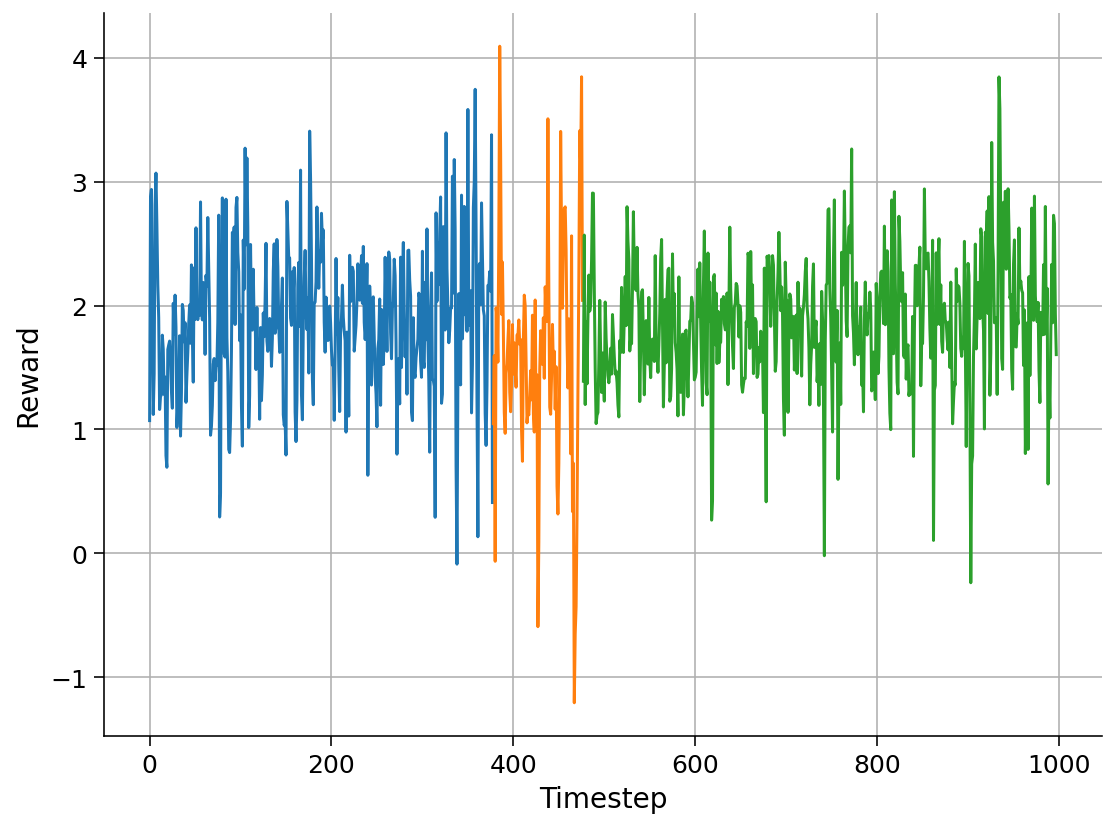

In [ ]:
env_step = 0
for episode in reward:
  plt.plot(np.arange(env_step, env_step+len(episode)), episode)
  env_step += len(episode)
plt.xlabel('Timestep', fontsize=14)
plt.ylabel('Reward', fontsize=14)
plt.grid()
plt.show()

## Total reward

Finally, let's print the total reward for the test episodes

In [ ]:
for i, episode in enumerate(reward):
  print(f"Total reward in episode {i}: {sum(episode):.2f}")

Total reward in episode 0: 710.55
Total reward in episode 1: 156.90
Total reward in episode 2: 969.62


## Saving and restoring training checkpoints to/from Google Drive

To avoid losing the training checkpoints during runtime restart, follow these steps:

### 1. Mount drive to temporarily save checkpoints

In [ ]:
# Mount drive. -- You may want to add your gDrive
drive.mount('/root/drive')

Mounted at /root/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2. BEFORE restarting the runtime, save checkpoint to drive

In [ ]:
!pwd

/content


In [ ]:
# Save agent checkpoint to drive.
save_ckpt_to_drive(agent)

Saved /root/acme/985f4298-f9b4-11eb-a762-0242ac1c0002/checkpoints/d4pg_learner to /content/drive/MyDrive/nma_rl/acme_ckpt


### 3. AFTER restarting the runtime, restore checkpoint from drive

To restore a checkpoint in the restarted Colab runtime:

1.   Re-install all the libraries and run all the cells as before, including the agent instantiation, **except** the training cell. 
2.   Run the cell below.
3.   Run the cell that instantiates the agent **again**.

In [ ]:
# Restore checkpoint from drive.
restore_ckpt_from_drive(agent)

Restored /root/acme/93cd634e-f49c-11eb-b5ed-0242ac1c0002/checkpoints/d4pg_learner from /root/drive/MyDrive/acme_ckpt


### 4. Optionally, unmount drive

In [ ]:
# Unmount drive.
drive.flush_and_unmount()

Drive not mounted, so nothing to flush and unmount.


---
# Examples of two additional agents:

## DMPO agent

In [ ]:
# Create networks.
policy_network, critic_network = make_networks_dmpo(action_spec)

# Create agent.
agent = DistributionalMPO(environment_spec=env_spec,
                          policy_network=policy_network,
                          critic_network=critic_network,
                          observation_network=tf2_utils.batch_concat,
                          policy_optimizer=policy_optimizer,
                          critic_optimizer=critic_optimizer,
                          logger=learner_logger,
                          checkpoint=checkpoint)

## DDPG agent

In [ ]:
# Create networks.
policy_network, critic_network = make_networks_ddpg(action_spec)

# Create agent.
agent = DDPG(environment_spec=env_spec,
             policy_network=policy_network,
             critic_network=critic_network,
             observation_network= tf2_utils.batch_concat, # Identity Op.
             logger=learner_logger,
             checkpoint=checkpoint)

---
# Good luck :)